<a href="https://colab.research.google.com/github/jszyxw/2048AI/blob/master/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 互联网数据挖掘 作业报告 数据分析部分

刘宇晗 1800013079

In [ ]:
import numpy as np
import pandas as pd

import unicodedata, re, string
import nltk

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
import os

## 数据集调研

In [ ]:
df_train = pd.read_csv("train.txt", sep="\t")
df_test = pd.read_csv("test1.txt", sep="\t")

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99989 entries, 0 to 99988
Data columns (total 2 columns):
Text       99989 non-null object
isRobot    99989 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [ ]:
df_train.head()

,Text,isRobot
0,A woman noticed something strange in her famil...,1
1,"On Monday, a North Korean soldier was shot six...",1
2,It's no secret that iOS rivals Android. We kno...,0
3,"So, you've decided to move on. You've signed o...",1
4,The Queens borough president celebrated New Ye...,0


In [ ]:
df_train['Text'][0]

'A woman noticed something strange in her family\'s photo album, in an old picture of herself recently. The 21-year-old journalist was looking through pictures when she found a ghostly little girl that appeared to be following her in one of the photos.  Anastassia Perets was looking through her family\'s photo album last month and she discovered an eerie photo of herself when she was 4-years-old. In the photo, Perets can be seen walking near a bird cage as a ghostly little girl is following closely behind her.  Perets claims that there was no other little girls in the house at the time of when the photo was taken. The ghost girl appears to have blonde hair and she can be seen wearing a long white gown and holding a stuffed animal toy.  "I present you with a recently discovered creepy photo of my childhood. That is all. And if the creepiness factor isn\'t obvious, it is because that girl in the background isn\'t a real person," Perets posted on the photo\'s description on her Facebook. 

样本数量的可视化：

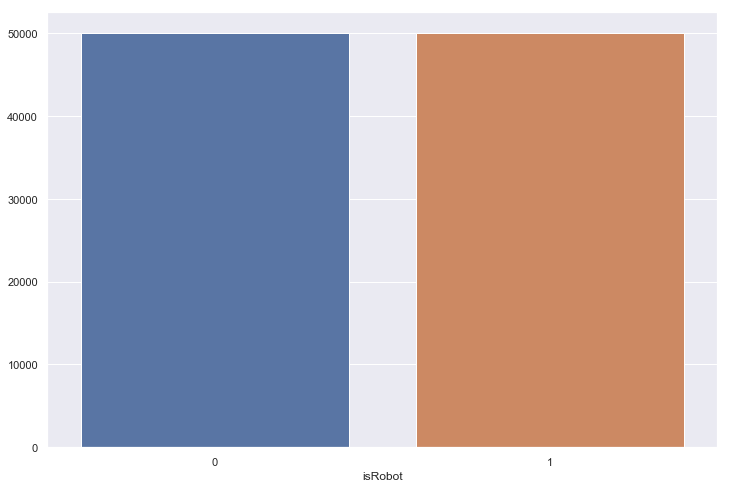

In [ ]:
dist = df_train.groupby(["isRobot"]).size()

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);

可以发现正负样本数据量相等。

Text(0.5, 1.0, 'distribution of text length in characters')

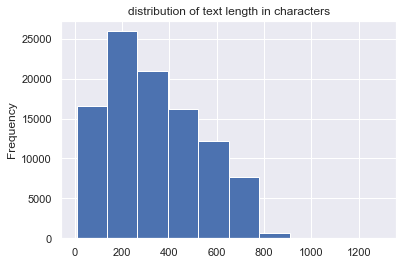

In [ ]:
df_train['Text'].apply(lambda x:len(x.split())).plot(kind='hist')
#plt.yscale('log');
plt.title('distribution of text length in characters')

可以发现大部分数据在510字以内，但也有一部分数据长度明显大于510字，即**超过bert-base的长度上限512**。

In [ ]:
fitLengthTextCount = sum(df_train['Text'].apply(lambda x:len(x.split())<512))
rate = fitLengthTextCount / len(df_train)
print("长度小于510的样本占总训练样本的比例为 %.2f %%" % (rate * 100))
maxTextLength = max(df_train['Text'].apply(lambda x:len(x.split())))
print("Max text length = %d" % maxTextLength)


长度小于510的样本占总训练样本的比例为 78.32 %
Max text length = 1294


Text(0.5, 1.0, 'distribution of text length in characters (characters > 510)')

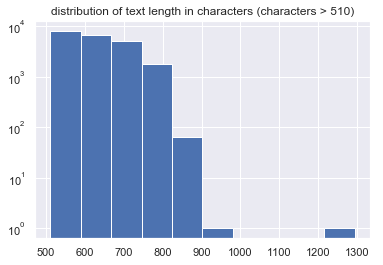

In [ ]:
lenMax = []
for i in df_train['Text'].apply(lambda x:len(x.split()) if len(x.split())>510 else 0):
    if i != 0:
        lenMax.append(int(i))
plt.hist(lenMax)
plt.yscale('log');
plt.title('distribution of text length in characters (characters > 510)')

可以发现除了一个长度为1294的超长样本之外，其他样本长度都在1000以内。
通过查阅相关论文等渠道，以下是文本超长问题的解决方法：
1. 直接截取前510个单词
2. 训练更大长度上限的bert模型
3. 使用滑动窗口算法，对单个样本进行分解样本->分别训练->合并训练结果
4. 使用其他对长度不敏感的模型
限于算力和时间，我使用的无参数训练的bert-base模型在colab上训练5个epoch需要8小时左右，**更大模型**或**更大训练量**的方法的时间耗费极有可能**超出colab的12小时运行时间限制**，所以这次作业我使用的是算法1。是算力不足的条件下的妥协方案。

训练后，根据结果获取测试集1上的性能指标：模型准确率，人类作者标签的F1，P，R

In [ ]:
f1 = open("test1.txt", "r", encoding = "utf8")
f2 = open("test1output.txt", "r", encoding = "utf8")

realLabel = []
predLabel = []

for i in f1.read().splitlines():
    if i[-1] == '1' or i[-1] == '0':
        realLabel.append(int(i[-1]))

for i in f2.read().splitlines():
    if i[-1] == '1' or i[-1] == '0':
        predLabel.append(int(i[-1]))

# print(len(realLabel), len(predLabel))

                 # Real Pred
TP = 0    # 1    1
FN = 0    # 1    0
FP = 0    # 0    1
TN = 0    # 0    0

for i in range(len(realLabel)):
    if realLabel[i] == 1 and predLabel[i] == 1:
        TP += 1
    if realLabel[i] == 1 and predLabel[i] == 0:
        FN += 1
    if realLabel[i] == 0 and predLabel[i] == 1:
        FP += 1
    if realLabel[i] == 0 and predLabel[i] == 0:
        TN += 1

print("TP = %d" % TP)
print("FN = %d" % FN)
print("FP = %d" % FP)
print("TN = %d" % TN)


TP = 4825
FN = 175
FP = 2206
TN = 2794


In [ ]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = (2 * precision * recall) / (precision + recall)

print("accuracy of human label: %.4f" % accuracy)
print("precision of human label: %.4f" % precision)
print("recall of human label: %.4f" % recall)
print("F1 of human label: %.4f" % F1)

accuracy of human label: 0.7619
precision of human label: 0.6862
recall of human label: 0.9650
F1 of human label: 0.8021


由上可知*模型*在测试集1上的准确率约为 $76.2\%$.
以上模型的测试结果仅代表训练在训练上述模型时仅跑了3个epoch，模型未收敛时的测试结果，详细原因请见作业报告——模型训练部分。